## Imports
These are the same imports as in the origional work notebook.

In [3]:
import matplotlib
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Focused fields
We're only going to be looking at these fields, for the same reason listed in the previous work document

In [17]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date'] #text
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'is_open']
user_fields = ['user_id', 'name', 'review_count', 'average_stars']

## Create Dataframes

In [18]:
business_df = pd.read_csv("yelp_business.csv", usecols=business_fields)
hours_df = pd.read_csv("yelp_business_hours.csv")
review_chunks = pd.read_csv("yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv("yelp_user.csv", usecols=user_fields, chunksize=500000)

## Sampleable
The sampleable class allows us to easily sample from the dataframes above. This is needed because the files we read in as chunks are read in as a `TextFileReader` object :( this allows us to use everything easily, and take samples effectively

In [19]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample): # Will always return the next chunk
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getRandomSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
hoursSampler = Sampleable(hours_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)

## Get sampling DataFrames

In [50]:
b_samp = businessSampler.getRandomSample(50000)
h_samp = hoursSampler.getRandomSample(50000)
r_samp = reviewSampler.getRandomSample(50000)
u_samp = userSampler.getRandomSample(50000)

## Random vs. Ordered & How to use Sampleable
The random sampling method will **always** generate a new random sample (without replacement) and store return it as a dataframe. Ordered sample will take the first `n` rows from the top of the dataframe down. It's important to know that if all of the dataframes may not neccesarily line up if you are constantly refreshing the sample. 

Noting that, it's important that if you're going ot merge a DataFrame on an attribute that you are taking a large enough sample (I've noticed that 10,000 is usually pretty good) to merge on the dataframe.

Similarily, it's important to note that these tables are necessarily lined up anyway. What I mean, is that when unless you're loading the majority of the businesses, you're likely unable to get a stable sample when merging two dataframes on an attribute.

If however, you need a normal sample, i.e the first `n` rows, taking an ordered sample will do that! 

In [51]:
b_samp_ordered = businessSampler.getOrderedSample(5000)
h_samp_ordered = hoursSampler.getOrderedSample(5000)
r_samp_ordered = reviewSampler.getOrderedSample(5000)
u_samp_ordered = userSampler.getOrderedSample(5000)

## Exceptions
To handle the exceptions that arise in the wrappers and utility functions

In [60]:
class MergeException(Exception):
    def __init__(message):
        super().__init__(message)

## Some Utility Functions
These are purley for making our lives a little easier.

## MergeWrapper
Merges two dataframes on a specified attribute

In [146]:
def mergeWrapper(df1, df2, attribute):
    if(not isinstance(d1, pd.core.frame.DataFrame) or not isinstance(df2, pd.core.frame.DataFrame)):
        raise MergeException("Arguments: DataFrame, DataFrame, String")
    if(not isinstance(attribute, str)):
        raise MergeException("Merging attribute must be a string")
    if(not attribute in df1 or not attribute in df2):
        raise MergeException("Couldn't find attribute {} in both dataframes!".format(attribute))
    if(not len(df1) == len(df2)):
        raise MergeException("Please make sure DataFrames are the same size!")
    df_final = pd.merge(df1.dropna(), df2.dropna(), on=attribute)
    return df_final

def createClusterData(*args):
    z = zip(*args)
    X = []
    for item in z:
        X.append(item)
    return X
        
def cluster(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    return centroids

## Graphing Object
The purpose of the graphing object is to store information about the graph such as the title, x and y labels, primary, secondary and tertiary colors.

In [54]:
class GraphInfo:
    def __init__(self, title, x_vars, y_vars,z_vars=(None, 'None')):
        self.title = title
        if(not isinstance(x_vars, tuple) or not isinstance(y_vars, tuple)):
            raise TypeError("X and Y vars should be tuples (value, name)")
        self.xvalue, self.yvalue, self.zvalue = x_vars[0], y_vars[0], z_vars[0]
        self.xlabel, self.ylabel, self.zlabel = x_vars[1], y_vars[1], z_vars[1]
        self.colors = ['Orange','Grey','Purple']
        
    def getTitle(self):
        return self.title
    def getLabel(self, label_name):
        if(label_name == 'x'):
            return self.xlabel
        elif(label_name == 'y'):
            return self.ylabel
        else:
            return self.zlabel
    def getColor(self, index):
        if(index >= len(self.colors)):
            return 'Black'
        return self.colors[index]

# Let's get to some DataMining

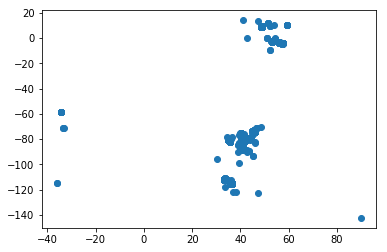

In [57]:
plt.scatter(b_samp['latitude'], b_samp['longitude'])
plt.title("")
plt.show()

In [58]:
focused_sample = b_samp[(b_samp['longitude'] < -50) & (b_samp['latitude'] <= 60) & (b_samp['latitude']>=0)]

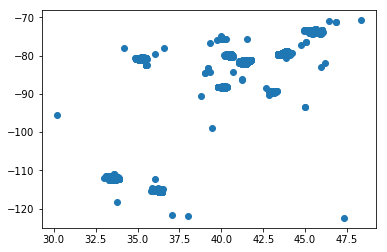

In [59]:
plt.scatter(focused_sample['latitude'], focused_sample['longitude'])
plt.show()